# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [28]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import string
import mwc.bayes
import mwc.stats
import mwc.viz
import mwc.fitderiv
import bebi103.viz
import pystan
import tqdm
import os
import csv
colors = mwc.viz.personal_style()
alt.data_transformers.enable('json')
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [3]:
DATE = 20190220
RUN_NO = 1
TEMP = 27
CARBON = 'glucose'
STRAIN = 'O2' #treat as operator if using mwc_growth strains

## Tidy the Data

First, remove unreadable glyphs from the Temperature column name in the data file. Then proceed below.

In [4]:
# Load the data. 
data = pd.read_csv(f'../../../../data/plate_reader/{DATE}_r{RUN_NO}_{TEMP}C_{CARBON}_{STRAIN}_growth.csv', skiprows=53)

# Trim rows beyond the timeseries data.
data = data[0:data[data['Time'] == 'Results'].index[0]].copy()

# Prune the nans
data.dropna(inplace=True)

# Convert the time to minutes
data['Time'] = data['Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1])+int(x[2])/60)

# Rename columns for simplicity
data.rename(columns={'Time':'time_min', 'T Read 2:600':'temp_C'}, inplace=True)

# Melt to longform tidy
data = data.melt(id_vars=['time_min', 'temp_C'])

# Rename variable and value vars.
data.rename(columns={'variable':'well_id', 'value':'od_600nm'}, inplace=True)

# Convert OD values to floats.
data['od_600nm'] = pd.to_numeric(data['od_600nm'])

# Rename well id to well number. 
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}
data['well_id'] = [alphanumeric_map[a] for a in data['well_id'].values]

# 'A','B','C','D','E','F','G','H'

# Include strain IDs and carbons.
strain_wells = {**{alphanumeric_map[f'{row}{col}']:'delta' for row in ['C','D','E','F'] for col in np.arange(3, 11, 1)}}
carbon_wells = {**{alphanumeric_map[f'{row}{col}']:'glucose' for row in ['C','D','E','F'] for col in np.arange(3, 11, 1)}}

for well in data['well_id'].unique():
    if well in strain_wells.keys():
        data.loc[data['well_id']==well, 'strain'] = strain_wells[well]
    else:
        data.loc[data['well_id']==well, 'strain'] = 'blank'
    if well in carbon_wells.keys():
        data.loc[data['well_id']==well, 'carbon'] = carbon_wells[well]
    else:
        data.loc[data['well_id']==well, 'carbon'] = 'blank'

# Insert identifier information. 
data['date'] = DATE
data['run_number'] = RUN_NO

# Save it to the output file
if os.path.exists('./output') == False:
    os.mkdir('./output')
data.to_csv(f'output/growth_plate.csv', index=False)

## Generate Plate Summary Figures 

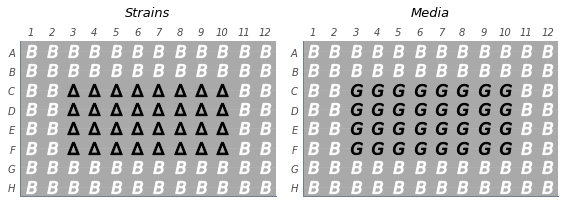

In [5]:
# Make array of media used.
carbon_map = np.full((8, 12), 'blank', dtype='<U10')
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        if 12*row+column+1 in carbon_wells.keys():
            carbon_map[row][column] = carbon_wells[12*row+column+1]

# Make array of strains used. 
strain_map = np.full((8, 12), 'blank', dtype='<U20')
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        if 12*row+column+1 in strain_wells.keys():
            strain_map[row][column] = strain_wells[12*row+column+1]
            
# Set up coloring and shape formatting.
carbon_color_dict = {'blank':'white', 'glucose':'black','LB':'red','glycerol':'blue','acetate':'purple'}
carbon_shape_dict = {'blank':'$B$', 'glucose':'$G$','LB':'$LB$','glycerol':'$Gy$','acetate':'$A$'}
strain_color_dict = {'blank':'white', 'delta':'black','manuel_delta':'black',
                     'geneva_LE':'lightblue','geneva_BW':'mediumpurple'}
strain_shape_dict = {'blank':'$B$', 'delta':'$∆$','manuel_delta':'$M∆$','geneva_LE':'$LE$','geneva_BW':'$BW$'}

# Set up plot and axes formatting.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].set_title('Strains', y=1.12, fontsize = 13)
ax[1].set_title('Media', y=1.12, fontsize = 13)
for i in range(2):
    ax[i].set_xlim([0.5, 12.5])
    ax[i].set_ylim([0.5, 8.5])
    ax[i].set_facecolor('darkgray')
    ax[i].set_yticklabels(('$H$','$G$','$F$','$E$','$D$','$C$','$B$','$A$'))
    ax[i].yaxis.set_ticks(np.arange(1,9,1))
    ax[i].xaxis.set_ticks(np.arange(1,13,1))
    ax[i].xaxis.tick_top()
    ax[i].tick_params(axis='both', which='both', top=False, left=False, labelsize='medium', pad=0)

# Plot strain and media glyphs.
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        ax[1].scatter(column+1, 8-row, s = 150, marker=carbon_shape_dict[carbon_map[row][column]], 
                    c=carbon_color_dict[carbon_map[row][column]])
for row in np.arange(0,8,1): 
    for column in np.arange(0,12,1):
        ax[0].scatter(column+1, 8-row, s = 150, marker=strain_shape_dict[strain_map[row][column]], 
                    c=strain_color_dict[strain_map[row][column]])

# Save figure.
plt.tight_layout()
plt.savefig(f'output/growth_plate_layout.png', bbox_inches='tight')

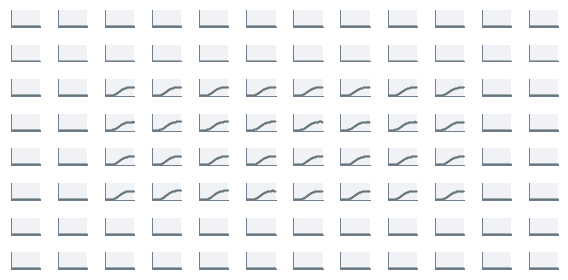

In [6]:
# Make summary growth curve figure.
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}
fig, ax = plt.subplots(8, 12, figsize=(8, 4))
for r in np.arange(0,8,1):
    for c in np.arange(0,12,1):
        ax[r][c].set_ylim([0, 1.5])
        ax[r][c].get_xaxis().set_visible(False)
        ax[r][c].get_yaxis().set_visible(False)
        row_letter = row_letters[r]
        well_id = alphanumeric_map[f'{row_letter}{c+1}']
        well_dat = data[data['well_id']==well_id]
        ax[r][c].scatter(well_dat['time_min'], well_dat['od_600nm'], marker='.', s=0.2)
plt.tight_layout()
plt.savefig(f'output/growth_plate_summary.png', bbox_inches='tight')

## Skipped: Clean Data

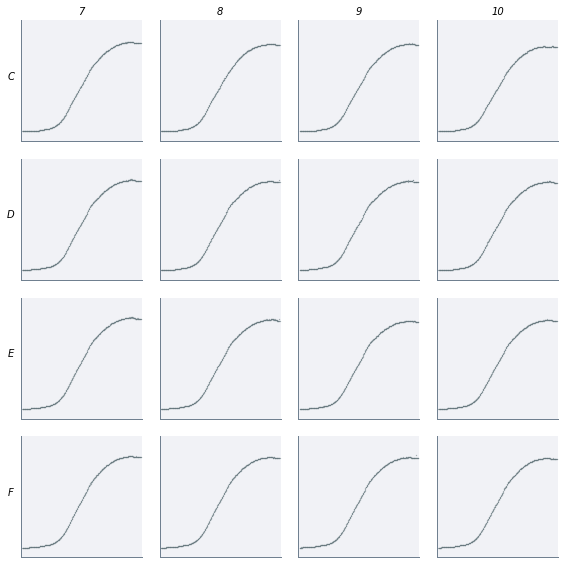

In [7]:
# Look for wells affected by plastic dust or OD spikes.
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}
excluded_wells = []
# for i in ['D5','D6','D7','E5','E6','E7','F5','F6','F7']:
#     excluded_wells.append(alphanumeric_map[i])

# Set viewing ranges
row_min, row_max, col_min, col_max = [2,6,6,10] 
# 0 refers to the first row or column (A or 1), set max 1 higher than the coordinate of the row or column you want to include
# To get the four middle rows, use 2,6. To get the eight middle columns, use 2,10.

fig, ax = plt.subplots(row_max-row_min, col_max-col_min, figsize=(8, 8))
for r in np.arange(row_min,row_max,1):
    for c in np.arange(col_min,col_max,1):
        ax[r-row_min][c-col_min].set_ylim([0, 1])
        ax[r-row_min][c-col_min].get_xaxis().set_visible(False)
        ax[r-row_min][c-col_min].get_yaxis().set_visible(False)
        row_letter = row_letters[r]
        well_id = alphanumeric_map[f'{row_letter}{c+1}']
        well_dat = data[data['well_id']==well_id]
        ax[r-row_min][c-col_min].scatter(well_dat['time_min'], well_dat['od_600nm'], marker='.', s=0.2)
        if well_id in excluded_wells:
            ax[r-row_min][c-col_min].set_facecolor('lavender')
for c in np.arange(0,col_max-col_min,1):
    ax[0][c].set_title(str(c+1+col_min),fontsize=10)
for r in np.arange(0,row_max-row_min,1):
    ax[r][0].get_yaxis().set_visible(True)
    ax[r][0].get_yaxis().set_ticks([])
    ax[r][0].set_ylabel(row_letters[r+row_min],rotation='horizontal',fontsize=10,labelpad=10)

plt.tight_layout()

In [7]:
# # Remove dirty wells. 
# data_full = data
# data = data[~data.well_id.isin(excluded_wells)].copy()

## Analysis 

In [8]:
# Generate a dictionary of the mean blank at each time point. 
blank_vals = {t:val['od_600nm'].mean() for t, val in data[data['strain']=='blank'].groupby(['time_min'])}

# Add mean blank values for each time point to the dataframe, as well as background subtracted OD values.
for k, v in blank_vals.items():
    data.loc[data['time_min']==k, 'blank_val'] = v
data['od_sub'] = data['od_600nm'] - data['blank_val']

Make the model we'll use to fit to exponential growth.

In [9]:
%%stan -v exp_growth
data {
    int<lower=0> N;
    real<lower=0> time[N];
    real<lower=0> absorb[N];
}

transformed data {
    real log_abs[N] = log(absorb);
}
parameters {
    real<lower=0> A_0;
    real<lower=0> lambda;
    real<lower=0> sigma;
}

model {
    A_0 ~ normal(0, 0.1);
    lambda ~ normal(0, 100);
    sigma ~ normal(0, 0.1);
    for (i in 1:N) {
        log_abs[i] ~ normal(log(A_0) + time[i] / lambda, sigma); 
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in exp_growth object.
Type exp_growth in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^
Access model compile output properties
exp_growth.model_file -> Name of stan_file [None]
exp_growth.model_name -> Name of stan model [None]
exp_growth.model_code -> Model code [data {     int<lower ....]


In [10]:
model = pystan.StanModel(model_code=exp_growth.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84499dfd991246c763c99f7879827f02 NOW.


In file included from /var/folders/2l/sd6bqywd6txgwwkbmf6jqbw40000gn/T/tmp2j3rraj4/stanfit4anon_model_84499dfd991246c763c99f7879827f02_3910354493770496045.cpp:600:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
1 warning generated.
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: ignoring file /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX10.14.sdk/usr/lib

### Delta in Glucose

In [9]:
current_strain = 'delta'
current_carbon = 'glucose'

In [44]:
stats['doubling time']

160.48057871532495

#### Plot the Data

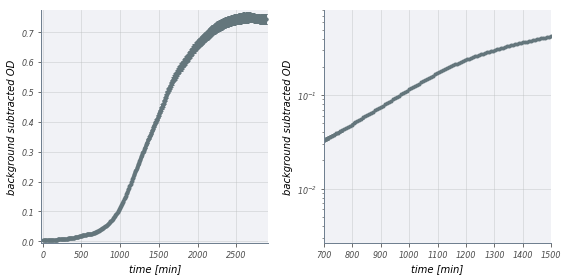

In [10]:
# Plot the growth data. 
grouped = data[(data['strain']==current_strain) & (data['carbon']==current_carbon)].groupby(
    ['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([700, 1500])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()
plt.savefig(f'output/{DATE}_{TEMP}C_{current_strain}_{current_carbon}_growth_curves_full_and_inset.png')

View all the datapoints in the linear (exponential) region.

Text(0,0.5,'background subtracted absorbance')

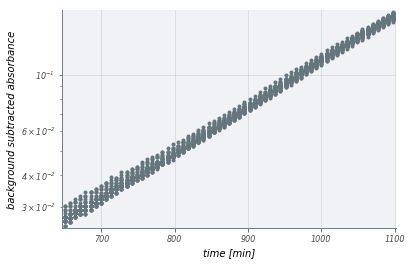

In [11]:
# Restrict to the desired range
restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                  (data['time_min'] >= 650) & (data['time_min'] <= 1100)].copy()
# Plot the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted absorbance', fontsize=10)

#### Skipped: Fit to an Exponential

Fit the model for all wells together, for a broad set of time ranges.

In [ ]:
growth_rates = []
growth_hpd_min = []
growth_hpd_max = []
for i in tqdm.tqdm(range(650, 1100, 40)):
    restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                      (data['time_min'] >= 0) & (data['time_min'] <= i)].copy()
    data_dict = {'N': len(restricted),
              'time': restricted['time_min'],
              'absorb': restricted['od_600nm']}
    samples = model.sampling(data_dict, iter=5000, control=dict(adapt_delta=0.95))
    samp_df = samples.to_dataframe()
    growth_rates.append(np.median(samp_df['lambda']))
    hpd_min, hpd_max = mwc.stats.compute_hpd(samp_df['lambda'], 0.95)
    growth_hpd_min.append(hpd_min) 
    growth_hpd_max.append(hpd_max)

In [ ]:
t_double = np.log(2) * np.array(growth_rates)
t_double_min = np.log(2) * np.array(growth_hpd_min)
t_double_max = np.log(2) * np.array(growth_hpd_max)

In [ ]:
fig, ax = plt.subplots(1, 1)
t = np.arange(650, 1100, 40)
ax.plot(t, t_double, '.')
ax.fill_between(t, t_double_min, t_double_max, alpha=0.5)
ax.set_ylabel('doubling time [min]')
ax.set_xlabel('number of time points considered')
ax.set_title(f'{current_strain}, {current_carbon}', fontsize=10)
plt.savefig(f'output/{current_strain}_{current_carbon}_time_dependence_inference_unsubtracted_abs.png')

Fit the model for each well separately and compile the results, for the data between 100 and 400 minutes.

In [ ]:
t_double = []
t_double_max = []
t_double_min = []

restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                  (data['time_min'] >= 400) & (data['time_min'] <= 1200)].copy()

for g, d in tqdm.tqdm(restricted.groupby(['well_id'])):
    data_dict = {'N': len(d),
              'time': d['time_min'],
              'absorb': d['od_sub']}
    samples = model.sampling(data_dict, iter=2000, control=dict(adapt_delta=0.95))
    samp_df = samples.to_dataframe()
    growth_rate_median = np.median(samp_df['lambda'])
    hpd_min, hpd_max = mwc.stats.compute_hpd(samp_df['lambda'], 0.95)
    t_double.append(np.log(2) * growth_rate_median)
    t_double_max.append(np.log(2) * hpd_min)
    t_double_min.append(np.log(2) * hpd_max)

In [ ]:
x_median = np.sort(t_double)
x_max = np.sort(t_double_max)
x_min = np.sort(t_double_min)
y = np.arange(0, len(t_double), 1)/len(x_median)
plt.step(x_median, y)
plt.fill_betweenx(y, x_min, x_max, alpha=0.5, step='post')
plt.ylim([0, 1])
plt.xlabel('doubling time [min]')
plt.ylabel('cumulative distribution')
plt.title(f'{current_strain}, {current_carbon}', fontsize=10)
plt.savefig(f'output/{current_strain}_{current_carbon}_cumulative_dist.pdf')

####  Using Gaussian Processes to Infer Growth Rates

In [12]:
restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) 
                  & (data['time_min'] > 650) & (data['time_min'] < 1100)].sort_values('time_min')

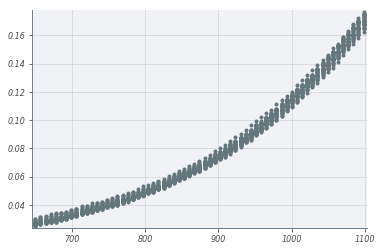

In [13]:
plt.plot(restricted['time_min'], restricted['od_sub'], '.')

Using the package [`fitderiv`](http://swainlab.bio.ed.ac.uk/software/fitderiv/) from Peter Swain's lab, we can perform non-parametric inference of the time-dependent growth rates of these data.

In [14]:
gp = mwc.fitderiv.fitderiv(restricted['time_min'].values, restricted['od_sub'].values)

Taking natural logarithm of the data.
Fitting measurement errors.
Using a squared exponential Gaussian process.
hparam[0] determines the amplitude of variation
hparam[1] determines the flexibility
hparam[2] determines the variance of the measurement error
log(max likelihood)= 4.368464e+03
hparam[0]= 1.071625e+01 [1.000000e-05, 1.000000e+05]
hparam[1]= 3.801904e-06 [1.000000e-06, 1.000000e+02]
hparam[2]= 8.564571e-04 [1.000000e-05, 1.000000e+02]

Calculating statistics with 100 samples
	(displaying mean +/- standard deviation [standard error])

         max df= 4.319884e-03 +/- 1.662687e-05 [1.662687e-06]
 time of max df= 9.479467e+02 +/- 7.435832e+00 [7.435832e-01]
 inverse max df= 1.604574e+02 +/- 6.180491e-01 [6.180491e-02]
          max y= 1.703336e-01 +/- 5.035793e-04 [5.035793e-05]
       lag time= 6.658087e+02 +/- 1.213028e+00 [1.213028e-01]


In [15]:
# Calculate doubling time and export summary statistics.
stats = gp.printstats(performprint=False).copy()
stats['doubling time']=(np.log(2)/gp.ds['max df'])

with open(f'output/{current_strain}_{current_carbon}_GP_summary.csv','w') as f:
    w = csv.writer(f)
    w.writerow(['parameter','value'])
    w.writerows(stats.items())

For exponential growth, the doubling time is ln(2)/λ, where lambda is the growth rate.

In [20]:
stats['doubling time']

160.45505438896882

In [22]:
stats

{'doubling time': 160.45505438896882,
 'inverse max df': 160.45743318098823,
 'inverse max df std': 0.6180490794721303,
 'inverse max df stderr': 0.06180490794721303,
 'lag time': 665.8086895463338,
 'lag time std': 1.2130279749670645,
 'lag time stderr': 0.12130279749670644,
 'max df': 0.004319883740649548,
 'max df std': 1.6626870913194555e-05,
 'max df stderr': 1.6626870913194556e-06,
 'max y': 0.1703336344681664,
 'max y std': 0.0005035793499610472,
 'max y stderr': 5.035793499610472e-05,
 'time of max df': 947.9466666666667,
 'time of max df std': 7.435832165938121,
 'time of max df stderr': 0.7435832165938121}

AttributeError: 'fitderiv' object has no attribute 'dt'

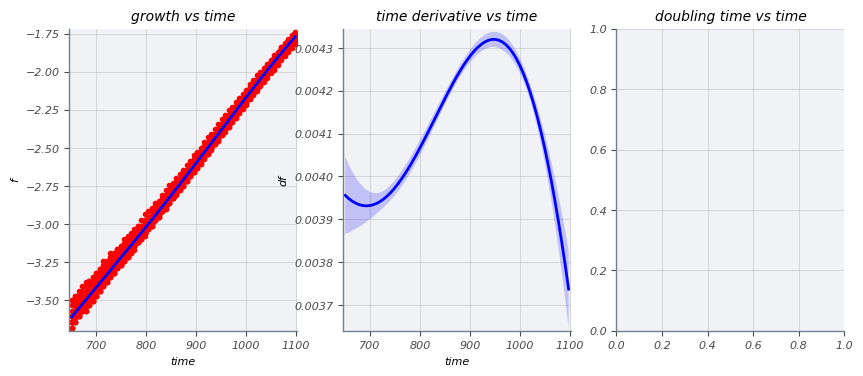

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.title('growth vs time', fontsize = 10)
gp.plotfit('f')
plt.subplot(1,3,2)
plt.title('time derivative vs time', fontsize=10)
gp.plotfit('df')
plt.subplot(1,3,3)
plt.title('doubling time vs time', fontsize=10)
gp.plotfit('dt')
plt.axhline(y=stats['doubling time'],c='red')
locs, _ = plt.yticks()
plt.yticks(np.append(locs[1:-1],round(stats['doubling time'],2)))
plt.tight_layout()
plt.savefig(f'output/{current_strain}_{current_carbon}_GP_fit_and_time_derivative.png')

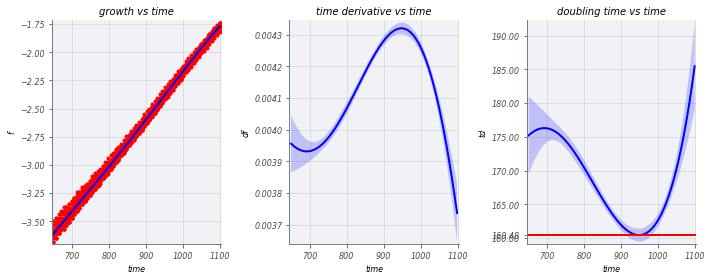

In [43]:
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.title('growth vs time', fontsize = 10)
gp.plotfit('f')
plt.subplot(1,3,2)
plt.title('time derivative vs time', fontsize=10)
gp.plotfit('df')
plt.subplot(1,3,3)
plt.title('doubling time vs time', fontsize=10)
gp.plotdoubtime()
plt.axhline(y=stats['doubling time'],c='red')
locs, _ = plt.yticks()
plt.yticks(np.append(locs[1:-1],round(stats['doubling time'],2)))
plt.tight_layout()
plt.savefig(f'output/{current_strain}_{current_carbon}_GP_fit_and_time_derivative.png')